# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [20]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

# Funciones de visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones de clustering
from sklearn.cluster import KMeans, MeanShift
from sklearn import manifold, preprocessing, decomposition

# Funciones propias
from utils_limpieza import * 

# Clear preferencias
plt.rcdefaults()
pd.reset_option('^display\.float_format')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Preparación de Datos <span style="color:magenta">**(Paso 1)**</span>

Se sintetizan todos los pasos de curación, a fin de tener a mano en caso de tener que revisar alguno de ellos. (Por hacer)

In [21]:
vectores = pd.read_csv('../data/interim/tp2_vendedores_vector_resumen.csv')
vectores.head()

,ID,Subrubro,Omega,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,...,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
0,0,Miscelaneo,1,0,0.580417,-0.388794,-0.965554,-0.987604,-0.987604,-0.943642,...,-0.119376,-0.352698,4055.855791,1.476730e+08,3787.351470,1.287680e+08,7470.411113,1.945619e+08,6987.879840,1.756728e+08
1,1,Miscelaneo,1,0,0.559349,0.591999,0.011470,-0.267213,-0.441588,-0.430018,...,0.475884,0.351416,35.874023,4.953037e+04,35.851674,4.953200e+04,69.548969,1.489747e+05,71.819984,1.539465e+05
2,2,Miscelaneo,1,0,0.012719,-0.010125,0.325712,0.167671,-0.260562,0.173718,...,-0.221058,-0.274480,1.670852,8.508866e+01,1.667198,8.509434e+01,2.757303,1.654879e+02,2.732026,1.713125e+02
3,4,Gondola,1,0,0.193896,0.072714,-0.055670,0.027243,-0.173982,0.008415,...,-0.396566,-0.151606,0.028906,4.450034e-02,0.010101,4.674346e-02,0.106075,1.108827e-01,0.039290,1.070464e-01
4,5,Com. Varios,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.188794,-0.188794,4.737902,1.428076e+02,4.700975,1.430781e+02,2.945724,1.647887e+01,2.466424,1.172261e+01


In [22]:
vectores.shape

(4616, 148)

In [23]:
# Definir grupos de variables:

F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 
         'F_pct_Com_1909', 'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912',
         'F_pct_Com_2001', 'F_pct_Com_2002', 'F_pct_Com_2003', 'F_pct_Com_2004',
         'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007', 'F_pct_Com_2008',
         'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
         'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104',
         'F_pct_Com_2105', 'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108',
         'F_pct_Com_2109', 'F_pct_Com_2110', 'F_pct_Com_2111', 'F_pct_Com_2112',
         'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203', 'F_pct_Com_2204',
         'F_pct_Com_2205', 'F_pct_Com_2206']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004',
         'Y_pct_Com_2005', 'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008',
         'Y_pct_Com_2009', 'Y_pct_Com_2010', 'Y_pct_Com_2011', 'Y_pct_Com_2012',
         'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103', 'Y_pct_Com_2104',
         'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
         'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112',
         'Y_pct_Com_2201', 'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204',
         'Y_pct_Com_2205', 'Y_pct_Com_2206']

Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004',
         'Y_pct_Ven_2005', 'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008',
         'Y_pct_Ven_2009', 'Y_pct_Ven_2010', 'Y_pct_Ven_2011', 'Y_pct_Ven_2012',
         'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103', 'Y_pct_Ven_2104',
         'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
         'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112',
         'Y_pct_Ven_2201', 'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204',
         'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

basics = ['Modelo', 'Subrubro']

In [24]:
#vectores_interes = vectores[basics + Y_Ven]
vectores_interes = vectores[Y_Ven]
vectores_interes.head()

,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,...,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
0,-0.980420,-0.965571,-0.965571,-0.987611,-0.987611,-0.943671,36606.764001,37024.978792,37024.978792,37024.978792,...,-0.997244,-0.997244,-0.919475,-0.450937,-0.819822,-0.147205,0.023844,-0.119376,-0.119376,-0.352698
1,0.032923,0.067118,-0.569663,-0.999617,-0.929885,-0.322981,-0.201898,-0.273524,-0.348675,-0.448290,...,0.353202,0.299397,0.244381,-0.052702,-0.021221,0.453017,0.027594,0.183219,0.475884,0.351416
2,0.256607,0.174306,-0.298710,-0.971207,-0.548703,-0.125982,0.097048,0.442733,2.131407,2.082447,...,-0.250917,-0.102872,-0.431158,-0.332711,-0.332390,0.737398,-0.645376,-0.433219,-0.221058,-0.274480
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,...,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.219453,0.191694,0.191694,0.191694,2.515726,-0.676641,1.093143,3.899372,-0.188794,-0.188794


In [25]:
vectores_interes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Y_pct_Ven_2001  3859 non-null   float64
 1   Y_pct_Ven_2002  3947 non-null   float64
 2   Y_pct_Ven_2003  3992 non-null   float64
 3   Y_pct_Ven_2004  4044 non-null   float64
 4   Y_pct_Ven_2005  4080 non-null   float64
 5   Y_pct_Ven_2006  4090 non-null   float64
 6   Y_pct_Ven_2007  4110 non-null   float64
 7   Y_pct_Ven_2008  4128 non-null   float64
 8   Y_pct_Ven_2009  4153 non-null   float64
 9   Y_pct_Ven_2010  4172 non-null   float64
 10  Y_pct_Ven_2011  4185 non-null   float64
 11  Y_pct_Ven_2012  4198 non-null   float64
 12  Y_pct_Ven_2101  4224 non-null   float64
 13  Y_pct_Ven_2102  4230 non-null   float64
 14  Y_pct_Ven_2103  4243 non-null   float64
 15  Y_pct_Ven_2104  4243 non-null   float64
 16  Y_pct_Ven_2105  4248 non-null   float64
 17  Y_pct_Ven_2106  4264 non-null   f

Hay problemas con los vacíos, para que me los tome el modelo:

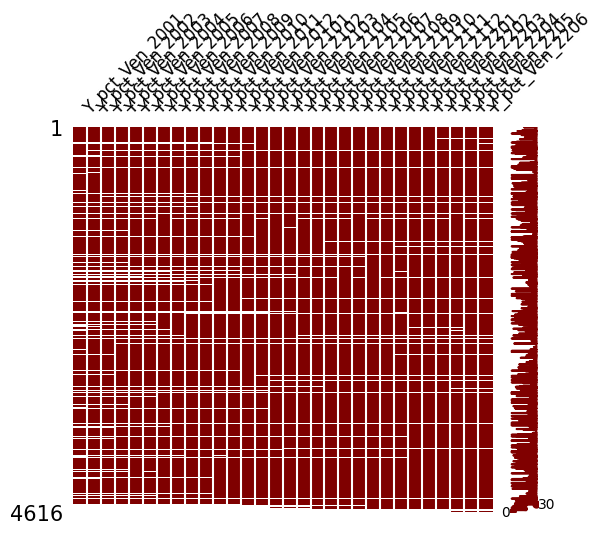

In [26]:
# Ventas anuales
vectores_interes = vectores[Y_Ven]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

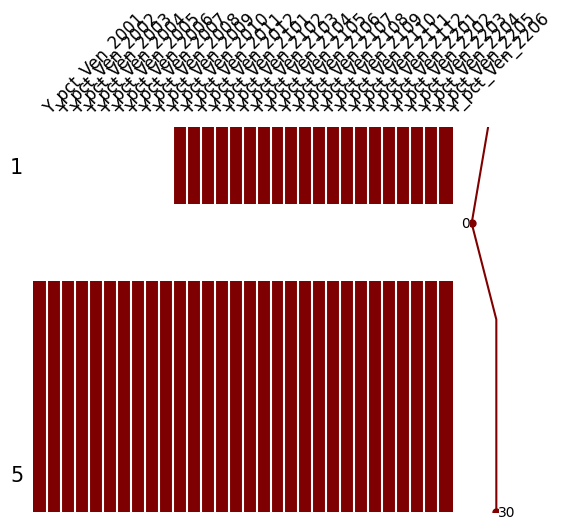

In [27]:
# Ventas anuales(zoom)
vectores_interes = vectores[Y_Ven]
msno.matrix(vectores_interes[185:190], fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

In [28]:
vectores.iloc[186, :]

ID                          118
Subrubro          Supermercados
Omega                         1
Modelo                        0
F_pct_Com_1905        -0.384912
                      ...      
F_com_var              0.127017
Y_ven_mean                  NaN
Y_ven_var                   NaN
Y_com_mean                  NaN
Y_com_var                   NaN
Name: 186, Length: 148, dtype: object

In [29]:
vectores['Y_pct_Ven_2109'].max()

203697461.3233292

In [30]:
vectores[vectores['Y_pct_Ven_2109'] == 203697461.3233292]

,ID,Subrubro,Omega,Modelo,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,...,Y_pct_Ven_2205,Y_pct_Ven_2206,F_ven_mean,F_ven_var,F_com_mean,F_com_var,Y_ven_mean,Y_ven_var,Y_com_mean,Y_com_var
4547,3017,Gondola,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.198553,-0.066005,0.519422,4.138001,8.818672e+06,1.399841e+15,0.354381,0.242742,2.036975e+07,4.149266e+15


In [31]:
ventas_fisc = pd.read_csv('../data/interim/tp2_ventas_fisc.csv')
ventas_fisc[(ventas_fisc['ID'] == 186) & (ventas_fisc['Subrubro'] == 'Com. Varios')]

,ID,Omega,Subrubro,Fecha,Deposito,Ventas,Comision,Modelo
330,186,1,Com. Varios,2019-01-01,72,0.000000e+00,0.000000,0
8755,186,1,Com. Varios,2019-02-01,72,0.000000e+00,0.000000,0
17761,186,1,Com. Varios,2019-03-01,72,0.000000e+00,0.000000,0
26215,186,1,Com. Varios,2019-04-01,72,0.000000e+00,0.000000,0
38862,186,1,Com. Varios,2019-05-01,72,1.435119e+06,46210.844285,0
42716,186,1,Com. Varios,2019-06-01,72,0.000000e+00,0.000000,0
51586,186,1,Com. Varios,2019-07-01,72,0.000000e+00,0.000000,0
64814,186,1,Com. Varios,2019-08-01,72,2.401762e+06,77336.723383,0
72244,186,1,Com. Varios,2019-09-01,72,3.921187e+05,12626.232911,0
81315,186,1,Com. Varios,2019-10-01,72,1.149312e+06,37007.838923,0


In [32]:
ventas_fisc[(ventas_fisc['ID'] == 186)]['Subrubro'].value_counts()

Subrubro
Com. Varios    42
Miscelaneo     42
Name: count, dtype: int64

**HACER**
- Llevar a cero todo lo que está entre -1000 y +1000 (esto antes del tratamiento de inflación)

20/9 >> 2.287884e-02
21/9 >> 4.660361e+06
3017	1	Gondola de dónde viene para dar ese 10-2?



In [33]:
ventas_fisc[ventas_fisc['ID'] == 3017]

,ID,Omega,Subrubro,Fecha,Deposito,Ventas,Comision,Modelo
176197,3017,1,Com. Varios,2020-09-01,145,2.287884e-02,0.000000,0
176198,3017,1,Gondola,2020-09-01,26,2.287884e-02,0.000000,0
185288,3017,1,Com. Varios,2020-10-01,145,2.204956e-02,0.000000,0
187164,3017,1,Gondola,2020-10-01,26,1.706689e+06,81067.714847,0
194445,3017,1,Com. Varios,2020-11-01,145,2.137420e-02,0.000000,0
196888,3017,1,Gondola,2020-11-01,26,3.549038e+06,168579.294571,0
203643,3017,1,Com. Varios,2020-12-01,145,2.055101e-02,0.000000,0
206079,3017,1,Gondola,2020-12-01,26,3.879836e+06,184292.208430,0
212972,3017,1,Com. Varios,2021-01-01,145,1.975128e-02,0.000000,0
215502,3017,1,Gondola,2021-01-01,26,3.631697e+06,172505.600282,0


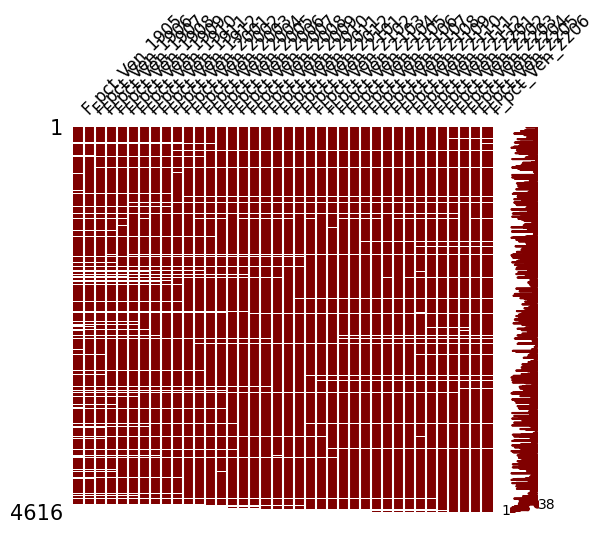

In [34]:
# Ventas cuatrimestrales
vectores_interes = vectores[F_Ven]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

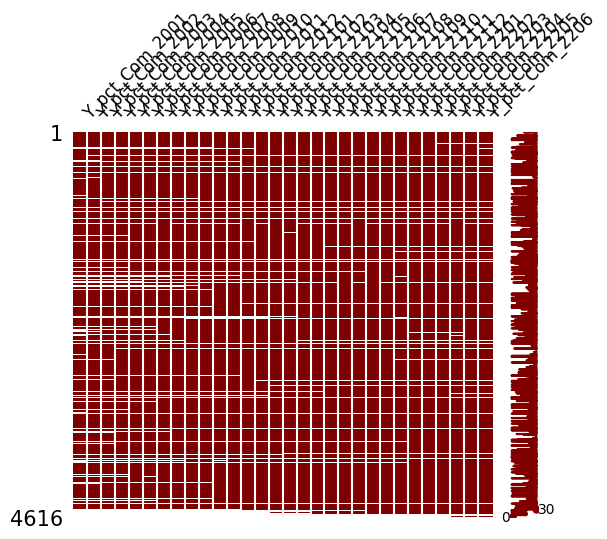

In [35]:
# Comisiones anuales
vectores_interes = vectores[Y_Com]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

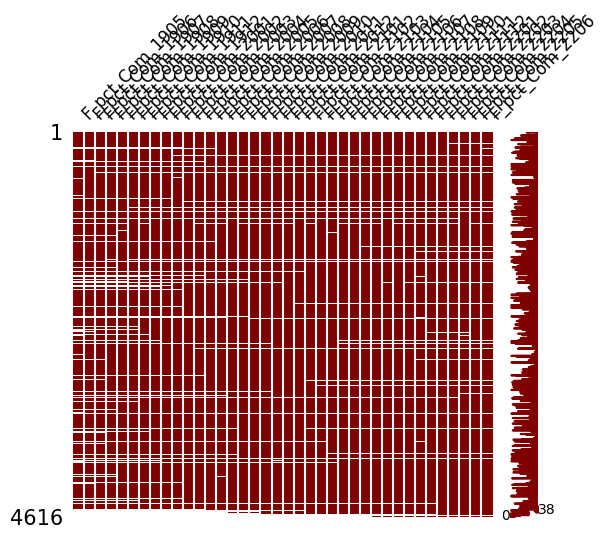

In [36]:
# Comisiones cuatrimestrales
vectores_interes = vectores[F_Com]
msno.matrix(vectores_interes, fontsize=12, color=[0.5,0,0], figsize=(6, 5))
plt.show()

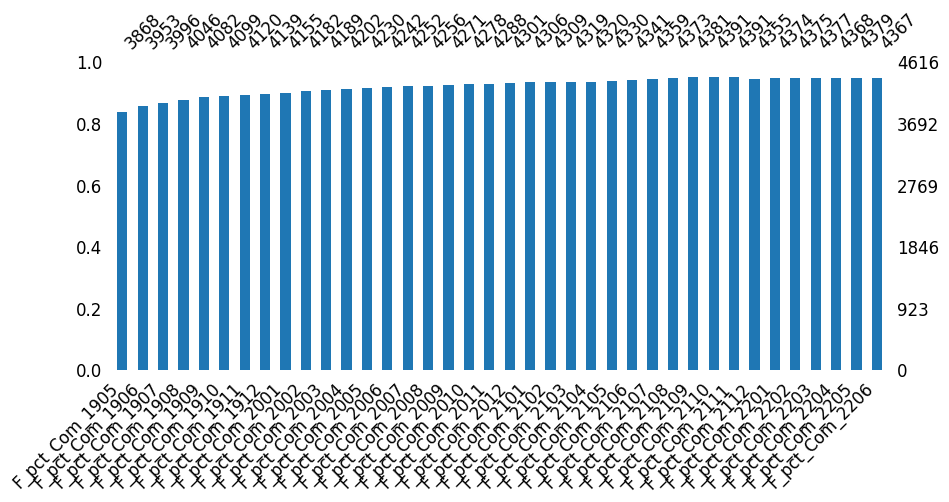

In [37]:
msno.bar(vectores_interes, fontsize=12, color="tab:blue", figsize=(10, 4))
plt.show()

In [39]:
# Paso 1: Contar valores vacíos por fila
vacios_por_fila = vectores_interes.isnull().sum(axis=1)

# Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
resumen = vacios_por_fila.value_counts().reset_index()
resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
resumen.head()

# ** Chequear **  >> Esto borra teniendo en cuenta yearly

,Cantidad de Valores Vacíos,Número de Filas
0,0,3598
1,1,176
3,2,57
2,3,57
4,4,49


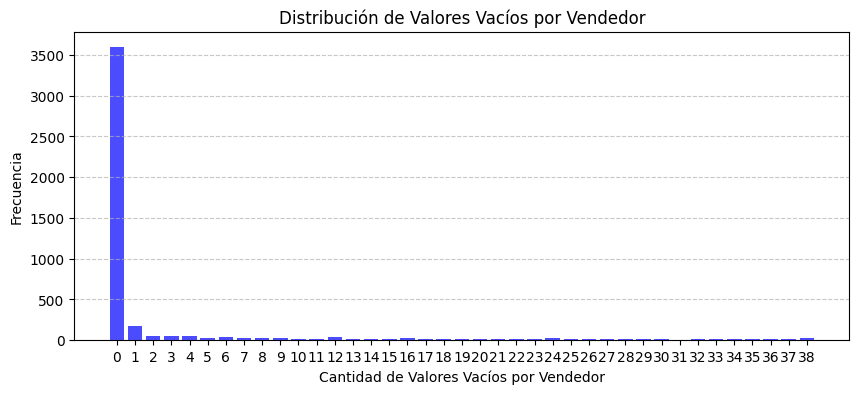

In [40]:
plt.figure(figsize=(10, 4))  # Tamaño del gráfico
plt.bar(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], color='blue', alpha=0.7)
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor')
plt.xticks(resumen['Cantidad de Valores Vacíos'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Muestra el gráfico
plt.show()


También hay problema de outliers. Qué significa que una variación me dé -20.000%. Que tenía ej 1.000.000 y pasé a 0,05?. Algo hay que hacer

In [41]:
vectores_interes.describe()

,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,...,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206
count,3868.000000,3953.000000,3996.000000,4046.000000,4082.000000,4099.000000,4120.000000,4139.000000,4155.000000,4182.000000,...,4381.000000,4391.000000,4391.000000,4355.000000,4374.000000,4375.000000,4377.000000,4368.000000,4379.000000,4367.000000
mean,2.375846,5.546659,5.597380,28.001350,10.165991,-89.368638,4.298042,2.540219,-2.258090,-2.667764,...,1.054552,2.076783,1.138573,2.484777,1.092821,2.870795,3.697015,1.022746,3.894425,8.158376
std,49.097333,210.456143,127.748469,2051.956551,295.114894,5972.022749,151.430541,50.855124,229.912625,229.017011,...,46.992403,45.813493,16.154325,46.668579,21.785555,102.903171,88.888724,53.144819,100.878436,279.625416
min,-21.539346,-57.848824,-15.596433,-33309.280521,-20.881502,-382237.527791,-509.466939,-129.794379,-14780.454653,-14780.454653,...,-1018.431829,-199.068867,-133.176232,-105.984016,-105.984016,-105.984016,-51.632256,-1605.107739,-1227.705344,-1327.011123
25%,-0.237828,-0.222104,-0.176841,-0.244860,-0.223731,-0.100489,-0.223436,-0.206437,-0.204762,-0.335935,...,-0.123534,-0.153760,-0.149497,-0.150306,-0.355459,-0.341494,-0.228671,-0.358280,-0.173340,-0.107696
50%,0.034498,0.031607,0.059695,0.022375,-0.016110,0.157378,0.000000,0.027339,0.100025,-0.050317,...,0.055459,0.017612,0.000000,0.025008,-0.084495,-0.102802,0.000000,-0.071471,0.036081,0.086034
75%,0.452488,0.410090,0.403583,0.353317,0.257373,0.576147,0.308368,0.391998,0.500461,0.220777,...,0.407540,0.335174,0.304193,0.411850,0.129715,0.082274,0.202464,0.172071,0.524835,0.486007
max,2551.443532,12981.678400,5722.739571,125432.602968,13631.321667,8613.656534,8613.656534,2878.598369,638.883697,735.902748,...,2576.389068,2576.389068,644.585122,1894.740427,1180.080551,6477.862809,3650.929829,2537.832381,4762.710442,17555.436058


ValueError: num must be an integer with 1 <= num <= 35, not 36

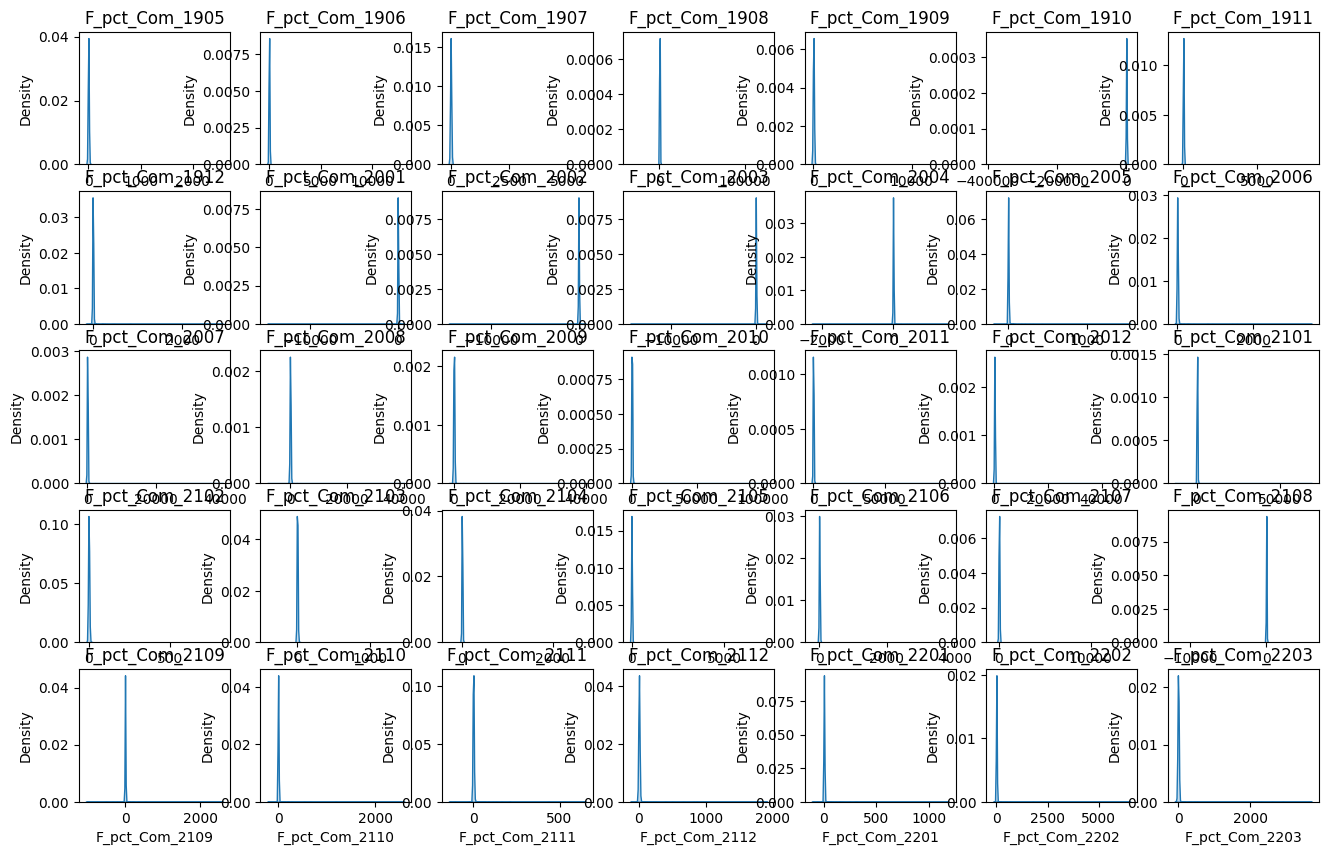

In [42]:
# # Configuración del diseño del gráfico
# plt.figure(figsize=(16, 10))  # Tamaño del layout

# # Itera a través de cada columna y crea un KDE plot
# for column in vectores_interes.columns:
#     plt.subplot(5, 7, vectores_interes.columns.get_loc(column) + 1)  # 5 filas, 7 columnas
#     sns.kdeplot(vectores_interes[column], fill=True)
#     plt.title(column)

# # Ajusta la disposición y muestra el gráfico
# plt.tight_layout()
# plt.show()

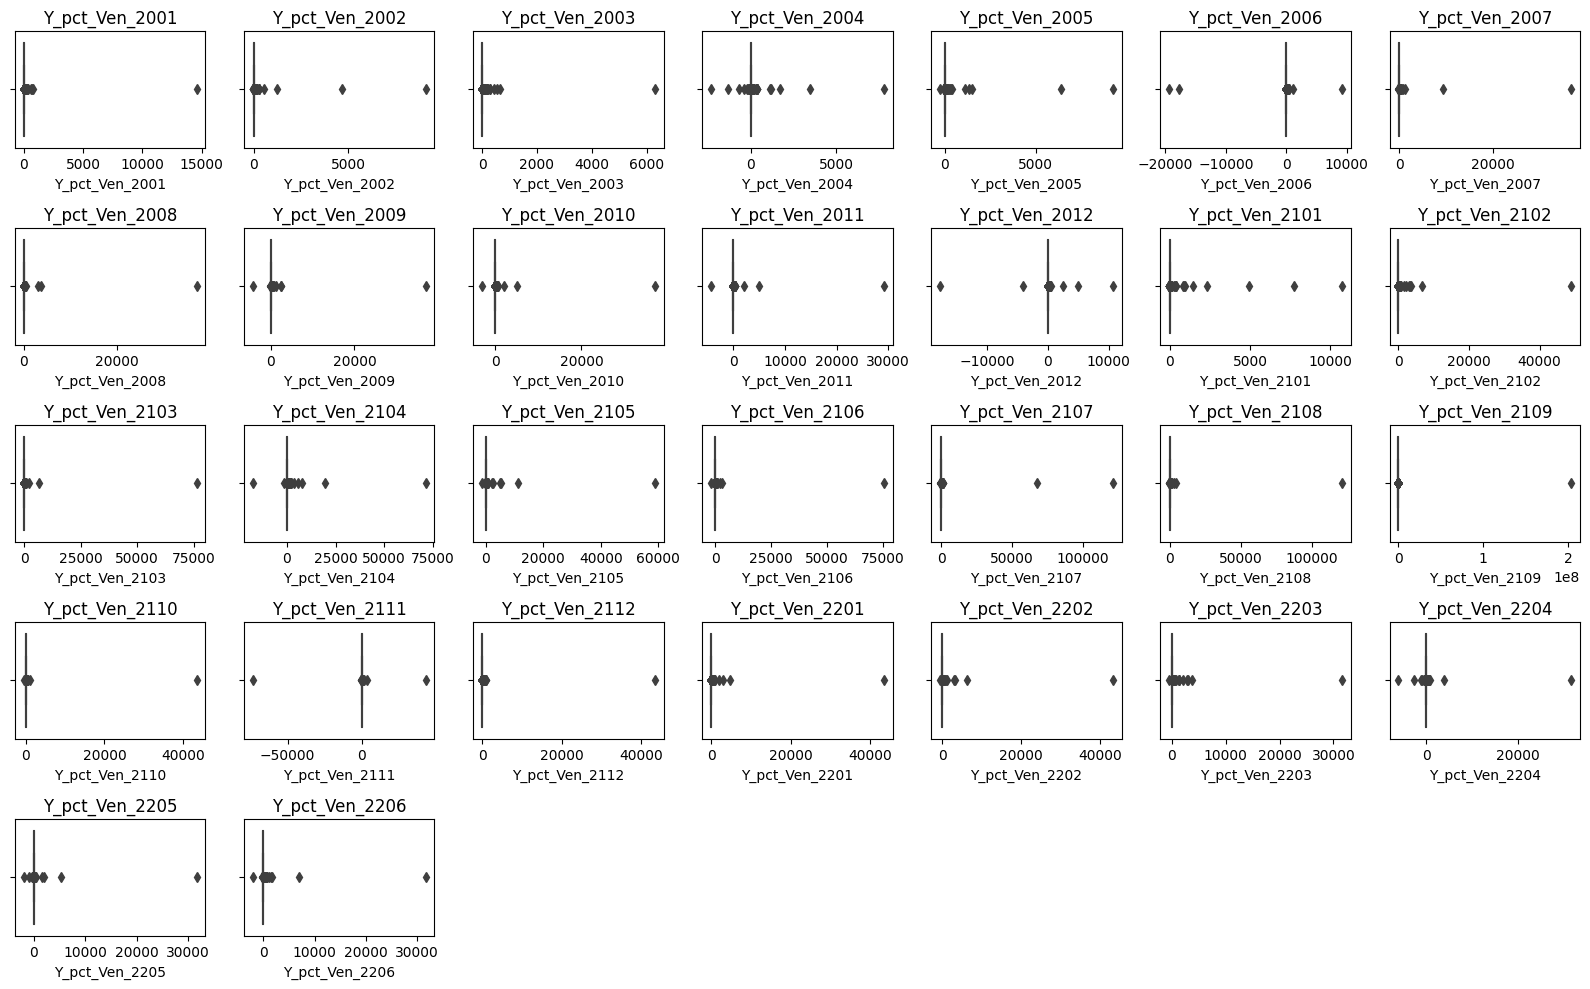

In [ ]:
# Configuración del diseño del gráfico
plt.figure(figsize=(16, 10))  # Tamaño del layout

# Itera a través de cada columna y crea un boxplot
for i, column in enumerate(vectores_interes.columns):
    plt.subplot(5, 7, i + 1)  # 5 filas, 7 columnas
    sns.boxplot(x=vectores_interes[column])
    plt.title(column)

# Ajusta la disposición y muestra el gráfico
plt.tight_layout()
plt.show()

---
## Selección del Número de Clusters <span style="color:magenta">**(Paso 2)**</span>

### Elbow method

Para probar, le quito los vacíos.

In [77]:
vectores_interes_sin_vacios.describe()

,F_pct_Com_1905,F_pct_Com_1906,F_pct_Com_1907,F_pct_Com_1908,F_pct_Com_1909,F_pct_Com_1910,F_pct_Com_1911,F_pct_Com_1912,F_pct_Com_2001,F_pct_Com_2002,...,F_pct_Com_2109,F_pct_Com_2110,F_pct_Com_2111,F_pct_Com_2112,F_pct_Com_2201,F_pct_Com_2202,F_pct_Com_2203,F_pct_Com_2204,F_pct_Com_2205,F_pct_Com_2206
count,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,...,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000,3598.000000
mean,2.348603,5.422422,3.531192,26.642896,5.431713,-104.478858,2.136464,2.449985,-2.880101,-3.452441,...,1.392636,1.752170,0.877381,1.819150,0.789816,1.215704,1.726775,0.098905,2.150073,7.657076
std,50.792055,218.616410,90.516842,2163.919689,190.725118,6372.605715,74.615106,53.742325,247.019539,246.798697,...,45.217909,47.967080,12.931853,37.661564,21.512705,33.318612,50.075471,39.168788,83.442421,301.128817
min,-21.539346,-57.848824,-7.578057,-33309.280521,-10.964912,-382237.527791,-509.466939,-129.794379,-14780.454653,-14780.454653,...,-490.668954,-199.068867,-105.984016,-105.984016,-105.984016,-105.984016,-51.632256,-1605.107739,-1227.705344,-1327.011123
25%,-0.236926,-0.209891,-0.166440,-0.220053,-0.212481,-0.088685,-0.220855,-0.195942,-0.188562,-0.333689,...,-0.118536,-0.157134,-0.150628,-0.152960,-0.363154,-0.341308,-0.225376,-0.358252,-0.170940,-0.105239
50%,0.031739,0.032573,0.063131,0.029950,-0.015832,0.164778,-0.000072,0.032423,0.121498,-0.067296,...,0.078118,0.038949,0.014128,0.048085,-0.107990,-0.119457,-0.002867,-0.090883,0.063621,0.111051
75%,0.440981,0.399805,0.385211,0.346950,0.252664,0.572037,0.307585,0.386071,0.498185,0.210546,...,0.409098,0.334416,0.308154,0.416807,0.125878,0.081562,0.200203,0.174502,0.531841,0.493666
max,2551.443532,12981.678400,4264.796627,125432.602968,9622.741647,2848.852167,4267.161575,2878.598369,638.883697,735.902748,...,2576.389068,2576.389068,644.585122,1894.740427,1180.080551,1775.031848,2897.640320,518.940476,4762.710442,17555.436058


In [117]:
gondola = vectores[vectores['Subrubro'] == 'Gondola']

#[basics + Y_Ven]
vectores_interes = gondola[Y_Ven]

In [118]:
vectores_interes_sin_vacios = vectores_interes.dropna().copy()
print(vectores_interes_sin_vacios.shape)

# me quedo con el +-500% que se ve como un 5 acá OJO
vec_pm500 = vectores_interes_sin_vacios.where((vectores_interes_sin_vacios < 5) & (vectores_interes_sin_vacios > - 5))
vec_pm500 = vec_pm500.dropna()

vectores_interes_sin_vacios = vec_pm500

(468, 30)


In [119]:
vec_pm500.describe()

,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,...,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.168879,0.114440,0.064296,0.007165,0.010354,0.136782,0.042137,0.025928,0.072428,-0.031905,...,0.147468,0.118259,0.146729,0.068724,0.099154,0.053869,0.033493,0.075036,0.125293,0.085757
std,0.789621,0.671106,0.695519,0.847713,0.609561,0.611332,0.559550,0.635107,0.623955,0.481981,...,0.646813,0.643005,0.569798,0.612545,0.654396,0.570073,0.534232,0.613100,0.598641,0.513375
min,-4.470329,-3.706283,-3.402870,-4.231448,-1.783419,-1.246282,-1.271814,-1.310989,-1.315219,-1.506827,...,-2.949025,-2.212189,-2.031825,-2.816481,-2.787518,-2.815717,-2.815717,-1.747936,-1.185962,-0.999107
25%,-0.151393,-0.177393,-0.235504,-0.380281,-0.310646,-0.183239,-0.262760,-0.286367,-0.255299,-0.267970,...,-0.164770,-0.174335,-0.122316,-0.195358,-0.178221,-0.162664,-0.162003,-0.215350,-0.148033,-0.186259
50%,0.014682,0.007437,-0.018825,-0.067035,-0.086291,0.054832,-0.033976,-0.054234,-0.000526,-0.068342,...,0.063109,0.022059,0.074842,0.009218,0.000000,0.000000,0.005215,0.000000,0.034593,0.004362
75%,0.276061,0.235579,0.192715,0.233712,0.210754,0.334958,0.226619,0.151527,0.271175,0.124865,...,0.310924,0.274647,0.295659,0.227029,0.230424,0.224390,0.186331,0.233189,0.308015,0.288948
max,4.986776,4.642092,4.717158,4.764456,4.016500,3.030262,2.836007,4.013188,3.564005,2.387835,...,3.950491,4.764822,4.452727,4.623333,4.437427,4.639431,3.269973,4.275461,3.677889,3.074349


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

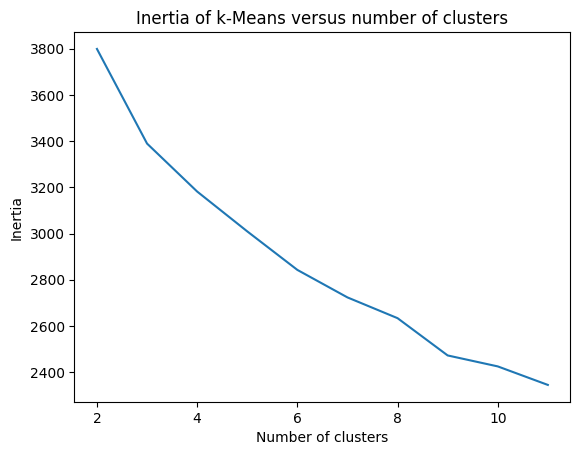

In [120]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_interes_sin_vacios).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

### Coeficiente Silhouette

---
## Aplicación de Modelos de Clustering <span style="color:magenta">**(Paso 3)**</span>

### K-means

In [125]:
km = KMeans(n_clusters=3, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_interes_sin_vacios)
clusters = km.labels_

In [126]:
vectores_clusters = vectores_interes_sin_vacios.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

Kmeans encontró:  3 clusters, nosotros forzamos la cantidad


,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,...,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,kmeans_4
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,...,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606,0
9,0.071386,-0.051197,-0.083747,0.010715,-0.068835,0.068352,0.126651,0.278542,0.021054,0.093775,...,-0.060587,0.431169,0.226544,0.142378,-0.030746,0.182961,0.202960,0.167332,0.048929,0
11,-0.221378,0.094467,-0.095069,0.563833,-0.251842,0.478978,-0.001720,0.412783,0.695157,-0.253389,...,1.110026,0.745267,-0.130876,-0.445690,-0.493564,-0.122608,0.439668,0.822868,0.106082,1
17,0.500167,0.503345,0.547481,0.344422,0.355886,0.408074,0.273444,0.245982,0.278328,0.146178,...,0.106417,0.001671,0.011519,-0.039148,-0.081689,-0.035290,-0.045252,-0.048187,0.043702,0


In [127]:
# Esto está hecho metiendo a todos los rubros en la misma bolsa
# Hacer por subrubro
vectores_clusters['kmeans_4'].value_counts()

kmeans_4
0    239
1     68
2     45
Name: count, dtype: int64

In [128]:
pca=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más,

pca.fit(vec_pm500) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(vec_pm500) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


proporción de varianza por componente:  [0.21668959 0.20790283]
proporción de varianza por componente acumulada:  [0.21668959 0.42459242]
tamaño de los datos:  (352, 2)


<Axes: xlabel='0', ylabel='1'>

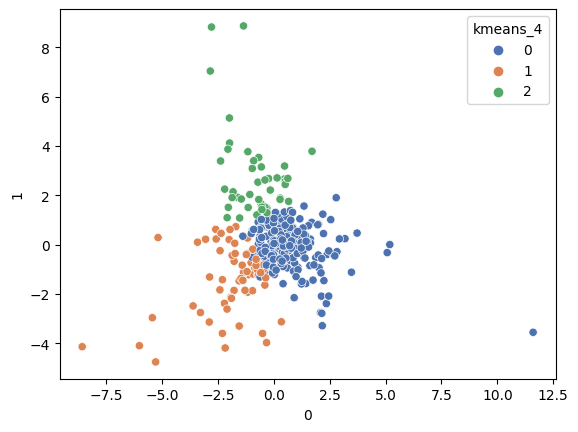

In [133]:
X_tsne_kmeans_4 = pd.DataFrame(X_projected)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")#, alpha=0.25)

# sns.pairplot(X_projected)

In [131]:
from sklearn import (manifold, preprocessing, decomposition)

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(vec_pm500)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 352 samples in 0.001s...
[t-SNE] Computed neighbors for 352 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 352 / 352
[t-SNE] Mean sigma: 0.762856
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.068657
[t-SNE] KL divergence after 1000 iterations: 0.897982


<Axes: xlabel='0', ylabel='1'>

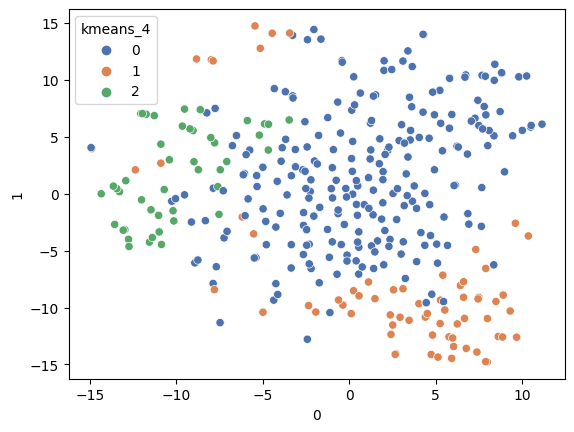

In [132]:
X_tsne_kmeans_4 = pd.DataFrame(X_tsne)
X_tsne_kmeans_4['kmeans_4'] = km.labels_

sns.scatterplot(data=X_tsne_kmeans_4,
                x=0, 
                y=1, 
                hue="kmeans_4", 
                palette="deep")

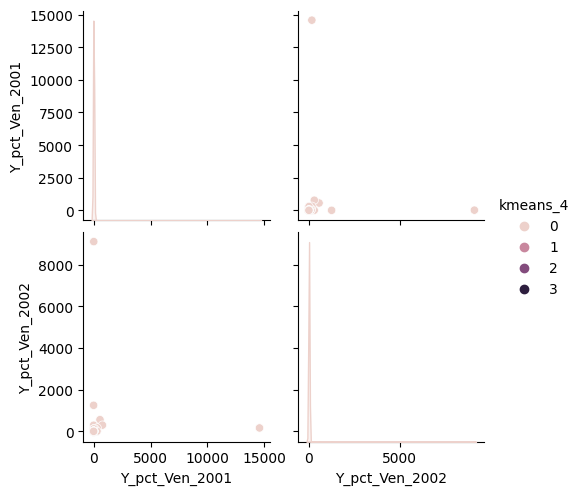

In [16]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

Probando para un solo rubro..

In [17]:
vectores_interes = vectores[basics + Y_Ven]
vectores_gondola = vectores_interes[vectores_interes['Subrubro'] == 'Gondola'].copy()
vectores_gondola = vectores_gondola.dropna().copy()
vectores_gondola

,Modelo,Subrubro,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,...,Y_pct_Ven_2109,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206
3,0,Gondola,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,...,0.168828,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606
9,0,Gondola,0.071386,-0.051197,-0.083747,0.010715,-0.068835,0.068352,0.126651,0.278542,...,0.131345,-0.060587,0.431169,0.226544,0.142378,-0.030746,0.182961,0.202960,0.167332,0.048929
11,0,Gondola,-0.221378,0.094467,-0.095069,0.563833,-0.251842,0.478978,-0.001720,0.412783,...,0.260517,1.110026,0.745267,-0.130876,-0.445690,-0.493564,-0.122608,0.439668,0.822868,0.106082
17,0,Gondola,0.500167,0.503345,0.547481,0.344422,0.355886,0.408074,0.273444,0.245982,...,-0.005894,0.106417,0.001671,0.011519,-0.039148,-0.081689,-0.035290,-0.045252,-0.048187,0.043702
18,1,Gondola,-0.126088,-0.132331,-0.104575,0.009693,-0.192917,-0.118210,-0.133327,-0.000331,...,-0.168458,-0.187445,-0.071311,-0.088320,0.207496,0.050226,-0.049518,-0.148213,-0.020871,-0.079855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,0,Gondola,0.337230,0.431850,0.177272,-0.053534,-0.183849,0.123884,0.100281,-0.215428,...,0.094559,-0.010832,0.122440,-0.069846,-0.256226,-0.102322,0.020811,0.232436,0.240241,0.203576
4479,0,Gondola,-0.519978,0.021659,-0.439678,-0.306915,1.053718,-0.382644,4.821066,5.425724,...,-0.116115,-0.096522,-0.108593,-0.022876,-0.078927,-0.004723,-0.287575,0.074358,-0.564454,-0.175172
4492,0,Gondola,3.399077,3.796687,2.552012,0.922400,0.973348,-0.430773,-0.432966,-0.436876,...,0.591134,0.064651,0.218940,0.307281,-0.719947,0.282367,0.288983,0.207571,-0.545627,0.175747
4503,0,Gondola,-0.201117,0.306558,-0.041610,0.148665,-0.180605,0.948029,0.295568,-0.470979,...,-0.212174,0.097009,0.109651,1.290904,0.324133,0.543724,-0.051137,-0.484126,0.339357,-0.318618


In [18]:
vectores_gondola = vectores_gondola[Y_Ven].copy()

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

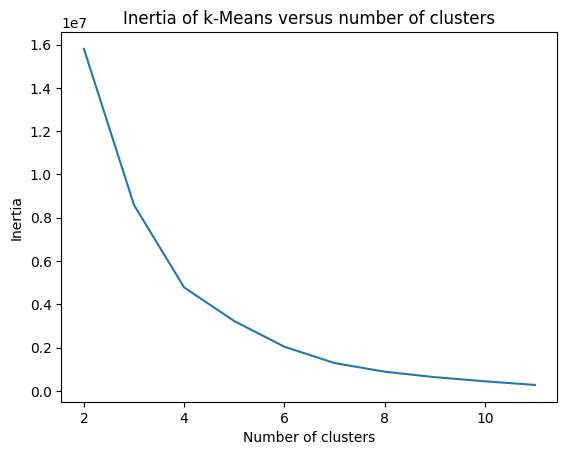

In [19]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, n_init=10).fit(vectores_gondola).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [20]:
km = KMeans(n_clusters=4, n_init=10) # El parámetro n_init igual a 10 me lo pide para no tirar error. Ver luego qué implica.
km.fit(vectores_gondola)
clusters = km.labels_

In [21]:
vectores_clusters = vectores_gondola.copy()
vectores_clusters['kmeans_4'] = km.labels_
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
vectores_clusters.head(4)

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


,Y_pct_Ven_2001,Y_pct_Ven_2002,Y_pct_Ven_2003,Y_pct_Ven_2004,Y_pct_Ven_2005,Y_pct_Ven_2006,Y_pct_Ven_2007,Y_pct_Ven_2008,Y_pct_Ven_2009,Y_pct_Ven_2010,...,Y_pct_Ven_2110,Y_pct_Ven_2111,Y_pct_Ven_2112,Y_pct_Ven_2201,Y_pct_Ven_2202,Y_pct_Ven_2203,Y_pct_Ven_2204,Y_pct_Ven_2205,Y_pct_Ven_2206,kmeans_4
3,-0.090954,-0.366634,-0.118110,-0.068514,-0.156388,-0.206558,-0.085699,-0.127638,0.153705,0.146317,...,-0.037599,-0.102040,-0.167593,-0.381054,-0.416867,-0.242169,-0.277885,-0.396566,-0.151606,0
9,0.071386,-0.051197,-0.083747,0.010715,-0.068835,0.068352,0.126651,0.278542,0.021054,0.093775,...,-0.060587,0.431169,0.226544,0.142378,-0.030746,0.182961,0.202960,0.167332,0.048929,0
11,-0.221378,0.094467,-0.095069,0.563833,-0.251842,0.478978,-0.001720,0.412783,0.695157,-0.253389,...,1.110026,0.745267,-0.130876,-0.445690,-0.493564,-0.122608,0.439668,0.822868,0.106082,0
17,0.500167,0.503345,0.547481,0.344422,0.355886,0.408074,0.273444,0.245982,0.278328,0.146178,...,0.106417,0.001671,0.011519,-0.039148,-0.081689,-0.035290,-0.045252,-0.048187,0.043702,0


In [22]:
vectores_clusters['kmeans_4'].value_counts()

kmeans_4
0    465
2      1
3      1
1      1
Name: count, dtype: int64

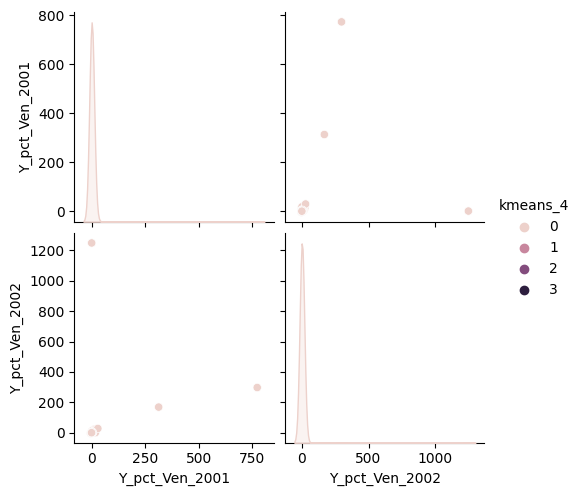

In [23]:
selected_columns = [Y_Ven[0], Y_Ven[1], 'kmeans_4']
sns.pairplot(vectores_clusters[selected_columns], hue='kmeans_4')

### Otros algoritmos de clustering

---
## Visualización de Resultados <span style="color:magenta">**(Paso 4)**</span>

---
## Interpretación y Evaluación <span style="color:magenta">**(Paso 5)**</span>

---
## Confianza en los Resultados <span style="color:magenta">**(Paso 6)**</span>

---
## Preguntas finales <span style="color:magenta">**(Paso 7)**</span>